In [230]:
import os

# inputs
natural_language_file = 'kinship_dutch.xlsx'
natural_language_name = 'dutch'
sweep_name="SeriousSweep20250205_170552"
hparams="vocab_size_32_max_len_3"
eval_path=f"results/uniform/outputs_{sweep_name}/{hparams}/"
seeds=[51, 52, 53, 54, 55]
emerged_languages_files = { f"seed{s}":
                            os.path.join(eval_path,f"evaluation_{hparams}_seed_{s}.csv") 
                            for s in seeds }

EGO = 'Bob'

In [231]:
# node mapping
NODES = [
    'MM', 'MF', 'MZy', 'MBy', 'M', 'MZe', 'MBe',
    'FM', 'FF', 'FZy', 'FBy', 'F', 'FZe', 'FBe',
    'Zy', 'By', 'Ego', 'Ze', 'Be', 'ZyD', 'ZyS',
    'ByD', 'ByS', 'D', 'S', 'ZeD', 'ZeS', 'BeD', 'BeS',
    'DD', 'DS', 'SD', 'SS'
]

## Complexity, information loss and accuracy for Dutch

In [232]:
import pandas as pd 

df = pd.read_excel(natural_language_file)
display(df)

,Target group,Word,Count
0,"MM, FM",Grootmoeder,1058
1,NaN,Oma,1097
2,"MF, FF",Grootvader,1440
3,NaN,Opa,723
4,F,Vader,19939
5,NaN,Papa,896
6,NaN,Pa,1346
7,M,Moeder,18009
8,NaN,Mama,1511
9,NaN,Ma,1186


In [233]:
from pandas import isna

counts = []
all_u = set()
all_w = set()

# collect counts
for _, row in df.iterrows():
    w = row['Word']
    us = row['Target group']
    if isna(us):
        counts[-1][2] += row['Count']
        continue # us = counts[-1][0] -- discard synonyms 
    else: 
        us = [u.strip() for u in us.split(',')]
    counts.append([us, row['Word'], row['Count']])
    all_u.update(set(us))
    all_w.add(w)
    
print('counts')
display(counts)

counts


[[['MM', 'FM'], 'Grootmoeder', 2155],
 [['MF', 'FF'], 'Grootvader', 2163],
 [['F'], 'Vader', 22181],
 [['M'], 'Moeder', 20706],
 [['MZy', 'MZe', 'FZy', 'FZe'], 'Tante', 819],
 [['MBy', 'MBe', 'FBy', 'FBe'], 'Oom', 1018],
 [['Zy', 'Ze'], 'Zus', 5395],
 [['By', 'Be'], 'Broer', 6657],
 [['D'], 'Dochter', 11958],
 [['S'], 'Zoon', 12490],
 [['DD', 'SD'], 'Kleindochter', 174],
 [['DS', 'SS'], 'Kleinzoon', 234],
 [['ZyD', 'ByD', 'ZeD', 'ByD'], 'Nicht', 774],
 [['ZyS', 'ByS', 'ZeS', 'ByS'], 'Neef', 1017]]

In [234]:
from collections import defaultdict
from itertools import product
from math import log2


def estimate_prob_given_count(counts):
    # collect counts with conditions
    count_u = defaultdict(lambda: 1e-10)  # for p(u)
    count_w_u = defaultdict(lambda: defaultdict(lambda: 1e-10))  # for p(w|u)
    count_u_w = defaultdict(lambda: defaultdict(lambda: 1e-10))  # for p(u|w)
    
    for us, w, c in counts:
        for u in us:
            count_u[u] += c / len(us)
            count_w_u[u][w] += 1
            count_u_w[w][u] += c / len(us)
    
    # estimate prob p(u), p(w|u), p(u|w)
    p_u = defaultdict(lambda: 1e-10, {u:count_u[u] / sum(count_u.values()) for u in count_u.keys()})
    
    p_w_u = defaultdict(lambda: defaultdict(lambda: 1e-10), {
        u:defaultdict(lambda: 1e-10, {
            w:count_w_u[u][w] / sum(count_w_u[u].values())
            for w in count_w_u[u].keys()
        })
        for u in count_w_u.keys()})
    
    p_u_w = defaultdict(lambda: defaultdict(lambda: 1e-10), {
        w:defaultdict(lambda: 1e-10, {
            u:count_u_w[w][u] / sum(count_u_w[w].values())
            for u in count_u_w[w].keys()
        })
        for w in count_u_w.keys()})
    
    return p_u, p_w_u, p_u_w


def compute_complexity_infoloss_accuracy(
    all_u, all_w, 
    p_u, 
    p_sender_w_u, p_sender_u_w, 
    p_receiver_u_w
):
    complexity = 0  # I(W,U) = sum_u_w p(u) x p(w|u) x log2( p(u|w) / p(u) ) 
    for u, w in product(all_u, all_w):
        complexity += (
            p_u[u] * 
            p_sender_w_u[u][w] * 
            log2(p_sender_u_w[w][u] / p_u[u])
        )
        
    info_loss = 0  # -sum_u_w p(u) x p(w|u) x log2(p(u|w))
    for u, w in product(all_u, all_w):
        info_loss += -p_u[u] * p_sender_w_u[u][w] * log2(p_receiver_u_w[w][u])
    
    acc = 0  # 
    for u, w in product(all_u, all_w): 
        acc += p_u[u] * p_sender_w_u[u][w] * p_receiver_u_w[w][u]
    
    return {
        'complexity': complexity,
        'info loss': info_loss,
        'accuracy': acc
    }


In [235]:
p_u, p_w_u, p_u_w = estimate_prob_given_count(counts)
nl_metrics = compute_complexity_infoloss_accuracy(
    all_u, all_w,
    p_u, 
    p_w_u, 
    p_u_w, 
    p_u_w
)
display(nl_metrics)

{'complexity': 2.890965283907938,
 'info loss': 0.2637137004262974,
 'accuracy': 0.8759288701974984}

## Complexity, information loss, accuracy for emergent language
Using natural-language's need probabilities

In [236]:
import json
import numpy as np 

# read evalutaion file 
def process_one_file(path: str, threshold: float = 1e-4):
    all_df = pd.read_csv(path)
    print(all_df.head())
    eme_lang = []
    
    for epoch in range(0, 10000):
        df = all_df[(all_df.Epoch == epoch) & (all_df["Ego Node"] == EGO)]
        if df.shape[0] == 0:
            continue
        
        # estimate counts with weights 
        counts_sender = []
        all_u = set()
        all_w = set()
        for _, row in df.iterrows(): 
            u, w = row['Target Node'], row['Message']
            counts_sender.append(([u], w, p_u[u]))  # assume that a target has only one name
            all_u.add(u)
            all_w.add(w)
        p_sender_u, p_sender_w_u, p_sender_u_w = estimate_prob_given_count(counts_sender)

        # make sure that p_u == p_sender_u
        for u, p in p_u.items():
            assert abs(p_sender_u[u] - p) < 1e-5, f"{[u, p, p_sender_u[u]]}"
        for u, p in p_sender_u.items():
            assert abs(p_u[u] - p) < 1e-5, f"{[u, p, p_u[u]]}"

        p_receiver_u_w = defaultdict(lambda: defaultdict(lambda: 1e-10))
        outputs = {}
        for _, row in df.iterrows(): 
            idx, u, w = row['Target Node Idx'], row['Target Node'], row['Message']
            receiver_output = json.loads(row['Receiver Output'])
            if isinstance(receiver_output[0], list):
                receiver_output = receiver_output[0]

            if w not in outputs:
                outputs[w] = receiver_output
            else: 
                assert all(abs(o-r)<threshold for o, r in zip(outputs[w], receiver_output)), \
                    [abs(o-r) for o, r in zip(outputs[w], receiver_output)]
            
            for uidx in range(len(receiver_output)):
                p_receiver_u_w[w][NODES[uidx]] = max(1e-10, receiver_output[uidx])
                        
        eme_lang.append({
                'epoch': epoch,
                'metrics': compute_complexity_infoloss_accuracy(
                    all_u, all_w,
                    p_u, 
                    p_sender_w_u, 
                    p_sender_u_w, 
                    p_receiver_u_w
                )
            }
        )
    return eme_lang

In [237]:
el_metrics = {}
for name, file in emerged_languages_files.items(): 
    el_metrics[name] = process_one_file(file)
    

   Epoch Ego Node  Target Node Idx Target Node Message  \
0     10      Bob                7          FM    [19]   
1     10      Bob               18          Be     [9]   
2     10      Bob               14          Zy    [10]   
3     10      Bob                6         MBe    [24]   
4     10      Bob               28         BeS    [10]   

                                     Receiver Output Predicted Label  Correct  \
0  [[0.24696241319179535, 0.22946572303771973, 1....              FF    False   
1  [[5.903252895222977e-05, 2.8682490665232763e-0...              Be     True   
2  [[8.002214390285193e-25, 2.534468093512171e-25...             BeD    False   
3  [[5.349366102596344e-17, 4.378818546275626e-17...             MBe     True   
4  [[8.002214390285193e-25, 2.534468093512171e-25...             BeD    False   

   Complexity  Information Loss  
0         NaN               NaN  
1         NaN               NaN  
2         NaN               NaN  
3         NaN               

## Plot

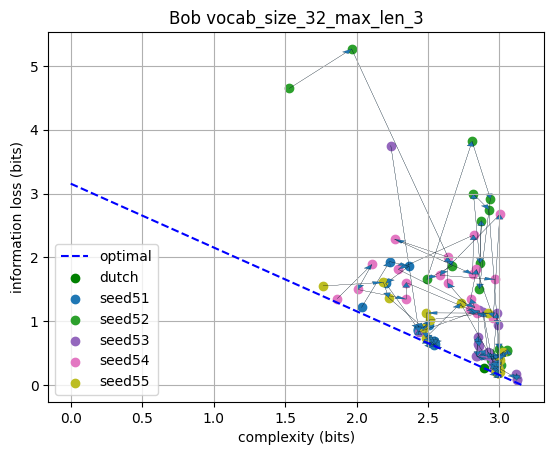

In [238]:
from matplotlib import pyplot as plt

# draw optimal boundary
# information loss = - complexity + entropy(u)
entropy_u = sum(-p_u[u] * log2(p_u[u]) for u in p_u.keys())
plt.plot([0, entropy_u], [entropy_u, 0], '--b')

# plot natural language
plt.scatter([nl_metrics['complexity']], [nl_metrics['info loss']], color='green')

# plot emerged language
def get_distinguishable_colors(n, cmap_name="tab10"):
    cmap = plt.get_cmap(cmap_name)
    return [cmap(i / n) for i in range(n)]
for el, color in zip(el_metrics.values(), 
                     get_distinguishable_colors(len(emerged_languages_files))):
    plt.scatter(
        [x['metrics']['complexity'] for x in el], 
        [x['metrics']['info loss'] for x in el], 
        color=color
    )

for el in el_metrics.values():
    for i in range(len(el)):
        l1, l2 = el[i-1]['metrics'], el[i]['metrics']
        if i > 0: 
            plt.arrow(
                l1['complexity'], l1['info loss'], 
                l2['complexity'] - l1['complexity'],
                l2['info loss'] - l1['info loss'],
                shape='full', lw=0.1, length_includes_head=True, head_width=.05
            )

plt.title(f"{EGO} {hparams}")
plt.xlabel('complexity (bits)')
plt.ylabel('information loss (bits)')
plt.legend(['optimal', natural_language_name] + list(el_metrics.keys()))
plt.grid()
plt.show()


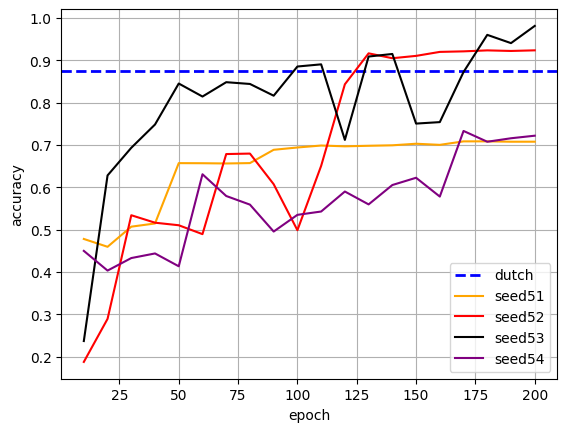

In [239]:
# plot accuracy

# plot natural language
plt.axhline(y=nl_metrics['accuracy'], color='b', linestyle='--', linewidth=2)

# plot emerged language
for el, color in zip(el_metrics.values(), ['orange', 'red', 'black', 'purple']):
    plt.plot(
        [x['epoch'] for x in el], 
        [x['metrics']['accuracy'] for x in el], 
        color=color
    )

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend([natural_language_name] + list(el_metrics.keys()))
plt.grid()
plt.show()